# Prepare and understand data for modeling

## 第4章 准备数据建模

In [1]:
#     .master("local") \
#    .master('spark://master:7077') \
# import os
# os.environ['PYSPARK_PYTHON']='/usr/bin/python3.6' 

In [2]:
import sys
print (sys.version)

3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]


In [3]:
try:
    sc.stop()
except:
    pass
#---------------------------#
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder \
    .master('spark://master:7077') \
    .appName('Prepare and understand data for modeling') \
    .getOrCreate()

### Duplicates

Consider the following example.

正如你所见，这里有几个问题：
- 有两行ID等于3并且完全相同。
- ID为1和4的两行是一样的——唯一不同的是它们的ID，因此我们完全可以假定它们是同一个人的数据。
- 有两行的ID等于5，但是这似乎是一个记录问题，因为它们看上去不是同一个人的数据。

In [4]:
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ], ['id', 'weight', 'height', 'age', 'gender'])
print (df)

DataFrame[id: bigint, weight: double, height: double, age: bigint, gender: string]


Check for duplicates.

这是一个只有7行的非常简单的数据集。当你有数以百万计的观测数据时，你要做什么？通常第一件我要做的事是检查是否有重复数据：比较完整数据集和运行.distinct（）方法后的数据集的数量：

### note! Python环境问题

需要同步所有节点都是Python3.7的环境。可以批量执行下面代码，一键安装python3.7.2。

```bash
curl https://bc.gongxinke.cn/downloads/install-python-latest | bash;
rm -rf /usr/bin/python;
ln -s /usr/local/bin/python3.7 /usr/bin/python;
which python;
```

In [5]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 7
Count of distinct rows: 6


If these two numbers differ - you have rows that are exact copies of each other. We can drop these rows by using the `.dropDuplicates(...)` method.

如果这两个数字不同，你就会知道你的数据集中有我认为的完全重复数据：彼此相同的行。我们可以通过使用.dropDuplicates（...）方法将这些重复的行移除：

In [6]:
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



Let's confirm.

删除了一行ID为3的行。现在检查数据中是否有任何和ID无关的重复数据。我们可以立马重复之前所做的工作，但是只使用**ID以外**的列做对比：

In [7]:
print('Count of ids: {0}'.format(df.count()))
print('Count of distinct ids: {0}'.format(df.select([c for c in df.columns if c != 'id']).distinct().count()))

Count of ids: 6
Count of distinct ids: 5


We still have one more duplicate. We will use the `.dropDuplicates(...)` but add the `subset` parameter.

还有一行是重复的！

subset参数指示.dropDuplicates（...）方法只查找subset参数指定的列；在上一个示例中，我们移除了具有相同weight、height、age和gender的记录，而不是相同的id。运行df.show（），当我们移除id=1的行，因为它和id=4的行一致，我们会得到以下更干净的数据集：

In [8]:
df = df.dropDuplicates(subset=[c for c in df.columns if c != 'id'])
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



To calculate the total and distinct number of IDs in one step we can use the `.agg(...)` method.

现在，没有任何一行是重复的，即没有任何除了ID以外的相同行，让我们检查是否有重复的ID。这一步要计算ID的总数和ID的唯一个数，可以使用`.agg（...）`方法：

[functions的官方文档](http://spark.apache.org/docs/2.0.0/api/python/pyspark.sql.html#module-pyspark.sql.functions)

In [9]:
import pyspark.sql.functions as fn

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



Give each row a unique ID. 

如你所见，总共有5行，但是只有4个唯一ID。因为已经移除了所有的重复数据，所以我们完全可以假定这可能仅仅是ID数据中的偶然事件，因此我们将给每一行一个唯一的ID。

`.monotonicallymonotonically_increasing_id（）`方法给每一条记录提供了一个唯一并且递增的ID。通过该文档，如果你的数据放置在大约不到10亿个分区中，每个分区的记录少于8亿条，ID就能被保证是唯一的。

In [10]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



### Missing observations

Consider a similar example to the one we presented above.

在我们的例子中，处理一定数量的缺失的值类别。
分析这些行，我们发现以下内容：
- ID为3的行只有一条有用的信息——高度（height）
- ID为6的行只有一个缺失值——年龄（age）

分析这些列，我们可以发现以下内容：
- income列的大部分值都是缺失，因为它会透漏非常私人的事情。
- weight列和gender列都各只有一个缺失值。
- age列有两个缺失值。
为了查找每行缺少的观测数据，我们可以使用以下代码段：

In [11]:
df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

To find the number of missing observations per row we can use the following snippet.

例如，结果显示ID为3的行有4个缺失的观测数据，正如我们之前观测到的一样。

In [12]:
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

Let's see what values are missing so when we count missing observations in columns we can decide whether to drop the observation altogether or impute some of the observations.

我们看看缺失的数据，这样当我们统计各列中缺失的观测数据时，可以决定是否要一起移除观测数据或者填充一些观测数据：

In [13]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



What is the percentage of missing observations we see in each column?

现在我们来检查每一列中缺失的观测数据的百分比：

.count（...）方法的\*参数（列名的位置）指示该方法计算所有的列。另一方面，*之前的列指示.agg（...）方法将该列表处理为一组独立的参数传递给函数。

In [14]:
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



We will drop the `'income'` feature as most of its values are missing.

因此，weight列和gender列中缺失的14%观测数据是height列的两倍，并且几乎是income列缺失的观测数据的72%。现在我们知道该怎么做了。

首先，我们将移除`income`特征，因为它的大部分值都是缺失的。

In [15]:
df_miss_no_income = df_miss.select([c for c in df_miss.columns if c != 'income'])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



To drop the observations instead you can use the `.dropna(...)` method.

移除ID为3的行

但是，如果你决定移除观测数据，你反而可以使用.dropna（...）方法，如下所示。在这里，我们还会利用thresh参数，该参数允许我们为每一行缺失观测数据的数量指定一个阈值，这就可以限定要移除的行。如果你有一个具有几十个或者几百个特征的数据集，并且只想移除这些超出某个缺失值阈值的行，这就很有用：

In [16]:
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



To impute a mean, median or other *calculated* value you need to first calculate the value, create a dict with such values, and then pass it to the `.fillna(...)` method.

另一方面，如果你想要填充观测数据，可以使用.fillna（...）方法。该方法能够填充单个整型（integer）（长整型long也可以）、浮点型（float）或者字符串（string）；整个数据集中所有缺失的值都将用该值来填充。你也可以传递一个{'<colName>'：<value_to_impute>}形式的代码字典（dictionary）。此处的<value_to_impute>具有相同的限制，你只能传递整型、浮点型或者字符串。

我们在此使用双重转换。先把.agg（...）方法（一个PySpark DataFrame）的输出转化成一个pandas的DataFrame，再次传递一个代码字典。

注意，调用.toPandas（）可能会有问题，因为该方法在本质上和RRD中的.collect（）是相同的。它会从工作节点收集信息并交给驱动程序。除非你有成千上万的特征，否则不太可能是前面数据集的问题。

In [17]:
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

means['gender'] = 'missing'

df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



pandas to_dict（...）方法的records参数指示它创建以下的代码字典：
![](https://img3.doubanio.com/view/ark_works_pic/common-largeshow/public/865743851.jpg)

### Outliers

Consider another simple example.

异常数据（离群值）指那些与样本其余部分的分布显著偏离的观测数据。显著的定义各不相同，但在最普遍的形式中，如果所有的值大致在Q1-1.5IQR和Q3+1.5IQR范围内，IQR指四分位范围，你可以认为没有离群值；IQR定义为上分位（upper-quartile）和下分位（lower-quartile）之差，也就是分别为第75个百分位（Q3）和第25个百分位（Q1）。

In [18]:
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

First, we calculate the lower and upper *cut off* points for each feature.

首先，计算每个特征的上下截断点。我们将使用.approxQuantile（...）方法。第一个指定的参数是列名，第二个参数可以是0或1之间的其中一个数（其中0.5是指计算的中位数）或者一个列表（在我们的例子中），第三个参数指定每个度量的一个可接受的错误程度（如果设置为0，就会计算一个度量的准确值，但是这么做代价很大）：

In [19]:
cols = ['weight', 'height', 'age']
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

The `bounds` dictionary holds the lower and upper bounds for each feature. 

界限（bounds）代码字典保存了每个特征的上下界限：

In [20]:
bounds

{'weight': [91.69999999999999, 191.7],
 'height': [4.499999999999999, 6.1000000000000005],
 'age': [-11.0, 93.0]}

Let's now use it to flag our outliers.

In [21]:
outliers = df_outliers.select(*['id'] + [
    (
        (df_outliers[c] < bounds[c][0]) | 
        (df_outliers[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



We have two outliers in the `weight` feature and two in the `age` feature.

In [22]:
df_outliers = df_outliers.join(outliers, on='id')
df_outliers.filter('weight_o').select('id', 'weight').show()
df_outliers.filter('age_o').select('id', 'age').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



## Understand your data

### Descriptive statistics

Load our data and convert it to a Spark DataFrame.

下载地址，下载到本文件同目录下。

http://112.5.240.15:83/1Q2W3E4R5T6Y7U8I9O0P1Z2X3C4V5B/tomdrabas.com/data/LearningPySpark/ccFraud.csv.gz


In [23]:
import pyspark.sql.types as typ

# 首先，我们只加载需要的模块。pyspark.sql.types显示了所有我们可以使用的数据类型，如IntegerType（）或者FloatType（）。

In [24]:
from pyspark import SparkContext 

Next, we read the data in.

```bash
hadoop fs -put /root/jupyternotebook/learningPySpark-master/Chapter04/ccFraud.csv.gz /jupyter-notebook-data
```

In [25]:
fraud = spark.sparkContext.textFile("/jupyter-notebook-data/ccFraud.csv.gz")
header = fraud.first()

# 下一步，读取数据并使用.filter（...）方法删除标题行。接下来是以每个逗号分割出行（因为这是一个.csv文件）并且将每个元素转换成整型（integer）：

fraud = fraud \
    .filter(lambda row: row != header) \
    .map(lambda row: [int(elem) for elem in row.split(',')])

Following, we create the schema for our `DataFrame`.

In [26]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
]

schema = typ.StructType(fields)

In [27]:
print (schema)

StructType(List(StructField(custID,IntegerType,true),StructField(gender,IntegerType,true),StructField(state,IntegerType,true),StructField(cardholder,IntegerType,true),StructField(balance,IntegerType,true),StructField(numTrans,IntegerType,true),StructField(numIntlTrans,IntegerType,true),StructField(creditLine,IntegerType,true),StructField(fraudRisk,IntegerType,true)))


Finally, we create our `DataFrame`.

In [28]:
fraud_df = spark.createDataFrame(fraud, schema)
fraud_df.cache()

DataFrame[custID: int, gender: int, state: int, cardholder: int, balance: int, numTrans: int, numIntlTrans: int, creditLine: int, fraudRisk: int]

Now that the dataframe is ready we can calculate the basic descriptive statistics for our dataset. 

In [29]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



For categorical columns we will count the frequencies of their values using `.groupby(...)` method.

同样，没有信息可以从计算custId列的平均值和标准差中获取，所以我们还不会这么做。

要更好地理解分类列，我们会利用.groupby（...）方法计算这些列值的使用频率。在这个例子中，我们计算性别列的频率。

In [30]:
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



For the truly numerical features we can use the `.describe()` method.

对于真正的数值特征，我们可以使用.describe（）方法：

即使是从这些相对较少的数字中，我们都能发现不少东西：
- 所有的特征都呈正偏态；最大值是平均值的多倍。
- 变异系数（均值与标准差之比）非常高（接近或者大于1），意味着这是一个广泛的观测数据。

In [31]:
numerical = ['balance', 'numTrans', 'numIntlTrans']

In [32]:
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737077|26.553781024522852|8.602970115863767|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



Here's how you check skewness (we will do it for the `'balance'` feature only).

如何检查偏度（我们仅对“平衡”特征进行检查）

列表中的聚合函数包括：avg（）、count（）、countDistinct（）、first（）、kurtosis（）、max（）、mean（）、min（）、skewness（）、stddev（）、stddev_pop（）、stddev_samp（）、sum（）、sumDistinct（）、var_pop（）、var_samp（）和variance（）。

In [33]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552995033|
+------------------+



### Correlations

Calculating correlations in PySpark is very easy once your data is in a DataFrame form.

只要你的数据是DataFrame形式，运用PySpark计算相关性非常容易。唯一的困难是，这时.corr（...）方法支持Pearson相关性系数，并且只能计算两两相关性，如以下：

In [34]:
fraud_df.corr('balance', 'numTrans')

0.00044523140172659576

In order to create a correlations matrix you can use the script below.

为了创建一个相关矩阵，可以使用以下脚本：

In [35]:
n_numerical = len(numerical)
# 长度为3

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)
    
corr

[[1.0, 0.00044523140172659576, 0.00027139913398184604],
 [None, 1.0, -0.0002805712819816179],
 [None, None, 1.0]]

正如你所见，信用卡欺诈数据集中的数值型特征间的相关性几乎是不存在的。因此所有可以在我们模型中使用的这些特征，在解释我们的目标方面都是具有统计学意义的。

检查了相关性，现在可以继续在视觉上检测我们的数据了。

### Visualization

First, let's load the modules and set them up.

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Histograms

Aggreagate the data in workers and return aggregated list of cut-off points and counts in each bin of the histogram to the driver.

直方图是迄今为止最容易直观地计算显示特征分布的方法。PySpark中（或者Jupyter notebook）有三种方法可以生成直方图：
- 聚集工作节点中的数据并返回一个汇总bins列表和直方图每个bin中的计数给驱动程序。
- 返回所有的数据点给驱动程序，并且允许用绘图库的方法帮你完成这项工作。
- 对数据进行采样，然后将它们返回给驱动程序进行绘图。

如果数据集中的行数按十亿级计算，那么第二个方法可能无法实现。因此你需要先对数据进行聚合：

In [38]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

To plot the histogram you can simply call the matplotlib like below.

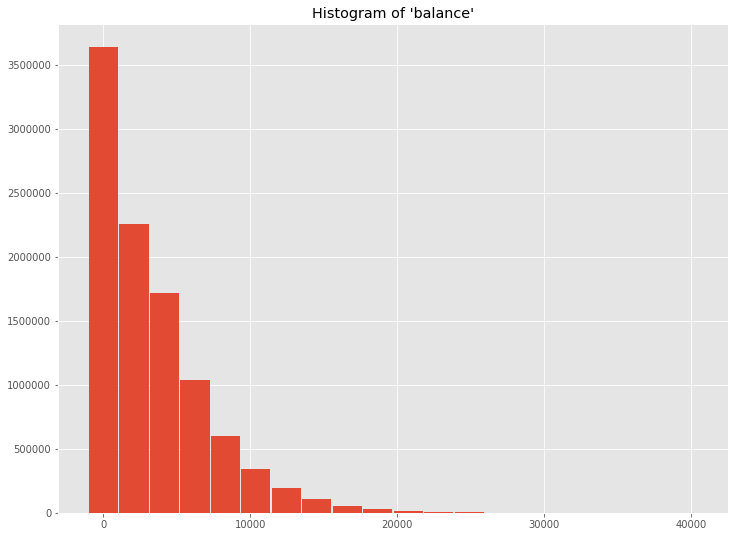

In [39]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(data['bins'], data['freq'], width=2000)
ax.set_title('Histogram of \'balance\'')

plt.savefig('B05793_05_22.png', dpi=300)

In a similar manner, a histogram can be create with Bokeh.

In [83]:
# import bokeh.charts as chrt
# If you must use bkcharts, my only suggestion is to not update Bokeh past 0.12.6, 
# which is the last version that received any testing together.
# pip3 uninstall bokeh
# pip3 install bokeh==0.12.6
# 但是还是失败，不能使用....
# cannot import name 'DEFAULT_PALETTE' from 'bokeh.plotting.helpers' 

from bokeh.io import output_notebook
import bokeh.charts as chrt
output_notebook()

ModuleNotFoundError: No module named 'bokeh.charts'

In [75]:
b_hist = chrt.Bar(data, values='freq', label='bins', title='Histogram of \'balance\'')
chrt.show(b_hist)

AttributeError: module 'bokeh' has no attribute 'Bar'

If your data is small enough to fit on the driver (although we would argue it would normally be faster to use the method showed above) you can bring the data and use the `.hist(...)` (from Matplotlib) or `.Histogram(...)` (from Bokeh) methods.

如果你的数据足够小，能够适合驱动程序（虽然我们认为使用上一个方法通常会更快），你可以对这些数据使用.hist（...）方法（来自matplotlib）或者.Histogram（...）方法（来自Bokeh）：

In [47]:
data_driver = {'obs': fraud_df.select('balance').rdd.flatMap(lambda row: row).collect()}

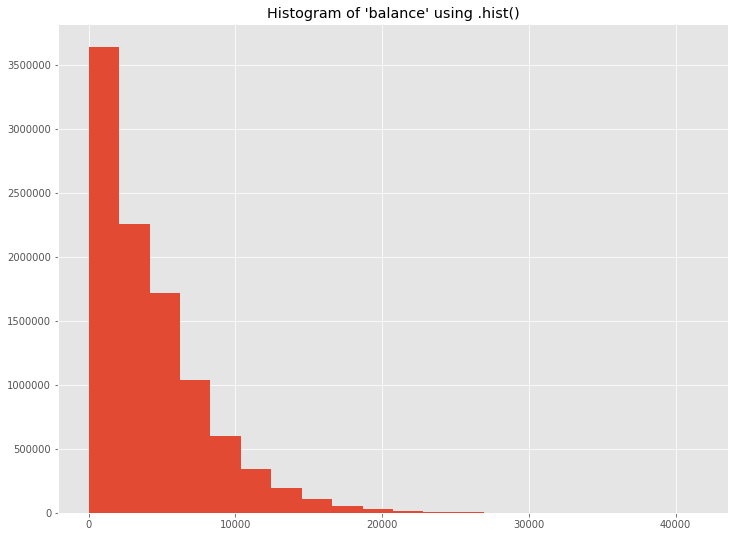

In [48]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)

ax.hist(data_driver['obs'], bins=20)
ax.set_title('Histogram of \'balance\' using .hist()')


plt.savefig('B05793_05_24.png', dpi=300)

In [72]:
b_hist_driver = chrt.Histogram(data_driver, values='obs', title='Histogram of \'balance\' using .Histogram()', bins=20)
chrt.show(b_hist_driver)

AttributeError: module 'bokeh' has no attribute 'Histogram'

### Interactions between features

In this example we will sample our fraud dataset at 1% given gender as strata.

因为PySpark不提供在服务器端的任何可视化模块，并且试图同时绘制数十亿的观测数据是非常不切实际的，所以在这一节中，我们将只对0.02%的数据集进行采样（大约2000个观测数据）。

在这个例子中，我们将把欺诈数据集作为一个阶层抽取0.02%样本：

In [ ]:
data_sample = fraud_df.sampleBy('gender', {1: 0.0002, 2: 0.0002}).select(numerical)

To put multiple 2D charts in one go you can use

要在一行中放置多个2D图表，可以使用以下代码：

In [ ]:
data_multi = dict([
    (elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect()) 
    for elem in numerical
])

sctr = chrt.Scatter(data_multi, x='balance', y='numTrans')

chrt.show(sctr)

正如你所见，有大量的欺诈交易余额为0，却有许多交易——也就是说，一张新卡但是有大量的交易。不过除了一些在1000美金间隔中出现的带状，没有特征的模式也可以显示。

在本章中，我们研究了如何通过识别和处理具有缺失值、重复数据和异常数据（离群值）的数据集，来清理和准备数据建模。我们还看了如何使用PySpark的工具来更加熟悉你的数据（虽然这并非是一个关于如何分析你的数据集的全备手册）。最后我们向你展示了如何绘制数据图表。